# Bayesian Inference for Time-Varying R(t) with the SAFIR Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/docs/notebooks/safir_inference.ipynb)

This notebook demonstrates how to:

1. Set up a realistic age-structured SAFIR model with UK demographics
2. Simulate a COVID-19-like epidemic with time-varying R(t) matching the UK 2020 pattern
3. Use Bayesian inference to estimate the time-varying R(t) from death data

The key feature is that **emidm**'s differentiable SAFIR model enables gradient-based inference, making it much faster than derivative-free methods.

---

**Authors:** Oliver (OJ) Watson. 2025. MIT Licence 2.0.
**Affiliation:** MRC-GIDA, School of Public Health, Imperial College London

## 1. Setup and Installation

In [17]:
# Install emidm with JAX and Bayesian inference support (uncomment if needed)
# !pip install "emidm[jax,bayes] @ git+https://github.com/OJWatson/emidm.git"

In [18]:
import os

# Prefer CPU for this notebook to avoid GPU OOM during end-to-end optimisation
# (especially under nbconvert execution).
os.environ.setdefault("JAX_PLATFORM_NAME", "cpu")

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

# Robust import: works both when emidm is installed and when running from repo
try:
    from emidm import (
        DiffConfig,
        make_diff_safir_model,
        optimize_params,
        run_blackjax_nuts,
        run_diff_safir_simulation,
    )
except ModuleNotFoundError:
    import sys
    from pathlib import Path

    cwd = Path.cwd().resolve()
    for p in [cwd] + list(cwd.parents):
        if (p / "src" / "emidm").exists():
            sys.path.insert(0, str(p / "src"))
            break
    from emidm import (
        DiffConfig,
        make_diff_safir_model,
        optimize_params,
        run_blackjax_nuts,
        run_diff_safir_simulation,
    )

# Set random seed for reproducibility
np.random.seed(42)

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

# Check if blackjax is available
try:
    import blackjax  # noqa: F401

    HAS_BLACKJAX = True
    print("BlackJAX available - will run MCMC")
except ImportError:
    HAS_BLACKJAX = False
    print("BlackJAX not available - install with: pip install blackjax")


JAX version: 0.4.30
Devices: [CpuDevice(id=0)]
BlackJAX available - will run MCMC


## 2. UK Demographics and Contact Matrix

We use a simplified 8 age-group structure based on UK demographics:
- 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70+

The contact matrix is derived from Prem et al. (2017, 2021) and represents average daily contacts between age groups in the UK.

In [19]:
# UK population by age group (in thousands, 2020 estimates)
# Age groups: 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70+
uk_population = np.array([
    8000,   # 0-9
    7500,   # 10-19
    8500,   # 20-29
    8800,   # 30-39
    8200,   # 40-49
    9000,   # 50-59
    7200,   # 60-69
    9800,   # 70+
]) * 1000  # Convert to actual population

# For computational efficiency, we scale down the population
# while maintaining the age structure
scale_factor = 1000  # 1:100k scaling for computational efficiency
population = (uk_population / scale_factor).astype(int)

print(f"Total population (scaled): {population.sum():,}")
print(f"Population by age group: {population}")


Total population (scaled): 67,000
Population by age group: [8000 7500 8500 8800 8200 9000 7200 9800]


In [20]:
# UK contact matrix (average daily contacts between age groups)
# Based on Prem et al. (2017) - simplified to 8 age groups
uk_contact_matrix = np.array([
    # 0-9   10-19  20-29  30-39  40-49  50-59  60-69  70+
    [4.50,  1.20,  0.80,  1.50,  1.20,  0.60,  0.40,  0.30],  # 0-9
    [1.20,  8.50,  2.00,  1.00,  1.50,  1.00,  0.50,  0.30],  # 10-19
    [0.80,  2.00,  5.50,  2.50,  1.50,  1.00,  0.60,  0.40],  # 20-29
    [1.50,  1.00,  2.50,  4.00,  2.00,  1.20,  0.70,  0.50],  # 30-39
    [1.20,  1.50,  1.50,  2.00,  3.50,  1.80,  0.90,  0.60],  # 40-49
    [0.60,  1.00,  1.00,  1.20,  1.80,  3.00,  1.50,  0.80],  # 50-59
    [0.40,  0.50,  0.60,  0.70,  0.90,  1.50,  2.50,  1.20],  # 60-69
    [0.30,  0.30,  0.40,  0.50,  0.60,  0.80,  1.20,  2.00],  # 70+
])

# Make the matrix symmetric (reciprocal contacts)
contact_matrix = (uk_contact_matrix + uk_contact_matrix.T) / 2

print("Contact matrix shape:", contact_matrix.shape)
print("Contact matrix:")
print(np.round(contact_matrix, 2))

Contact matrix shape: (8, 8)
Contact matrix:
[[4.5 1.2 0.8 1.5 1.2 0.6 0.4 0.3]
 [1.2 8.5 2.  1.  1.5 1.  0.5 0.3]
 [0.8 2.  5.5 2.5 1.5 1.  0.6 0.4]
 [1.5 1.  2.5 4.  2.  1.2 0.7 0.5]
 [1.2 1.5 1.5 2.  3.5 1.8 0.9 0.6]
 [0.6 1.  1.  1.2 1.8 3.  1.5 0.8]
 [0.4 0.5 0.6 0.7 0.9 1.5 2.5 1.2]
 [0.3 0.3 0.4 0.5 0.6 0.8 1.2 2. ]]


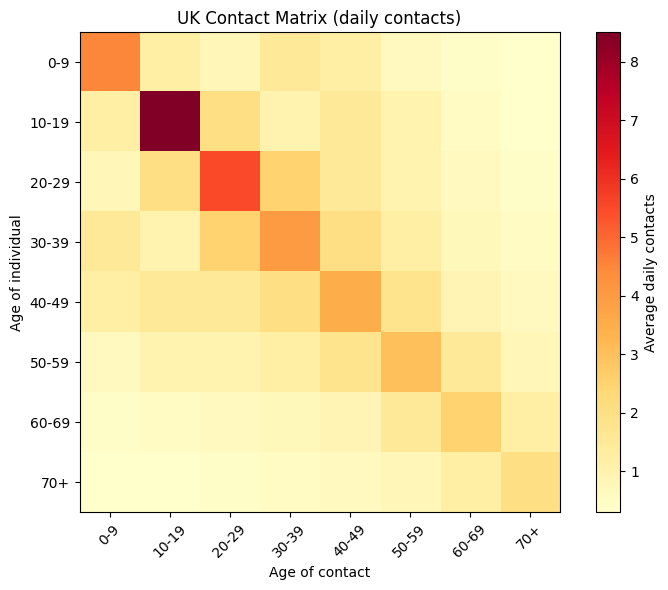

In [21]:
# Visualize the contact matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(contact_matrix, cmap='YlOrRd')
ax.set_xticks(range(8))
ax.set_yticks(range(8))
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
ax.set_xticklabels(age_labels, rotation=45)
ax.set_yticklabels(age_labels)
ax.set_xlabel('Age of contact')
ax.set_ylabel('Age of individual')
ax.set_title('UK Contact Matrix (daily contacts)')
plt.colorbar(im, label='Average daily contacts')
plt.tight_layout()
plt.show()

## 3. Simulating a UK-2020-like epidemic

We create a time-varying $R(t)$ with a qualitative UK 2020 pattern:

- **Early March**: rapid growth ($R > 2$)
- **Late March / April**: sharp reduction after first lockdown ($R < 1$)
- **Summer**: sustained low transmission ($R \approx 0.8\text{--}1.0$)
- **Autumn**: gradual increase ($R > 1$)
- **November**: short reduction (second lockdown)
- **December**: renewed increase

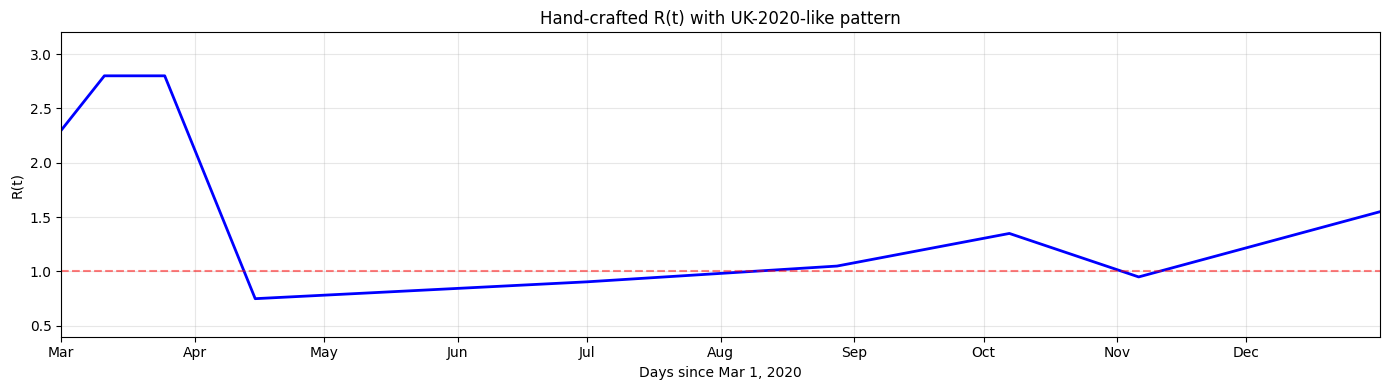

In [22]:
def create_uk_2020_rt(T=306):
    """Create a time-varying R(t) with a qualitative UK 2020 pattern.

    Days are indexed from 0 = Mar 1, 2020.

    This is not a fit to real UK data; it is a hand-crafted trajectory that
    produces a spring wave, a summer lull, and an autumn/winter resurgence.
    """
    days = np.arange(T + 1)

    # Piecewise-linear knots (day, R) chosen to mimic UK 2020 qualitatively.
    t_knots = np.array([0, 10, 24, 45, 120, 180, 220, 250, T], dtype=float)
    R_knots = np.array([2.3, 2.8, 2.8, 0.75, 0.9, 1.05, 1.35, 0.95, 1.55], dtype=float)

    R_t = np.interp(days, t_knots, R_knots)
    return R_t

# Full Mar->Dec 2020 window
T = 306
true_R_t = create_uk_2020_rt(T)

# Month labels for plotting (days since Mar 1)
months = ["Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_days = [0, 31, 61, 92, 122, 153, 184, 214, 245, 275]

fig, ax = plt.subplots(figsize=(14, 4))
days = np.arange(T + 1)
ax.plot(days, true_R_t, "b-", linewidth=2)
ax.axhline(y=1.0, color="r", linestyle="--", alpha=0.5)
ax.set_xlabel("Days since Mar 1, 2020")
ax.set_ylabel("R(t)")
ax.set_title("Hand-crafted R(t) with UK-2020-like pattern")
ax.set_xlim(0, T)
ax.set_ylim(0.4, 3.2)
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
print("Running SAFIR simulation...")

# Use a moderately smooth configuration so the "data" generation and inference
# model are consistent and differentiable.
obs_config = DiffConfig(tau=0.3, hard=False)

result = run_diff_safir_simulation(
    population=population,
    contact_matrix=contact_matrix,
    R0=2.5,
    R_t=true_R_t,
    T=T,
    dt=0.5,
    seed=42,
    config=obs_config,
    I0=5,
)

print(f"Simulation complete. Total deaths: {result['D'][-1]:.0f}")

# Create synthetic observed daily deaths by adding Poisson noise
mean_daily_deaths = np.diff(np.array(result["D"]), prepend=0)
mean_daily_deaths = np.clip(mean_daily_deaths, 0.0, None)
observed_deaths = np.random.poisson(lam=np.maximum(mean_daily_deaths, 1e-6)).astype(int)


Running SAFIR simulation...
Simulation complete. Total deaths: 240


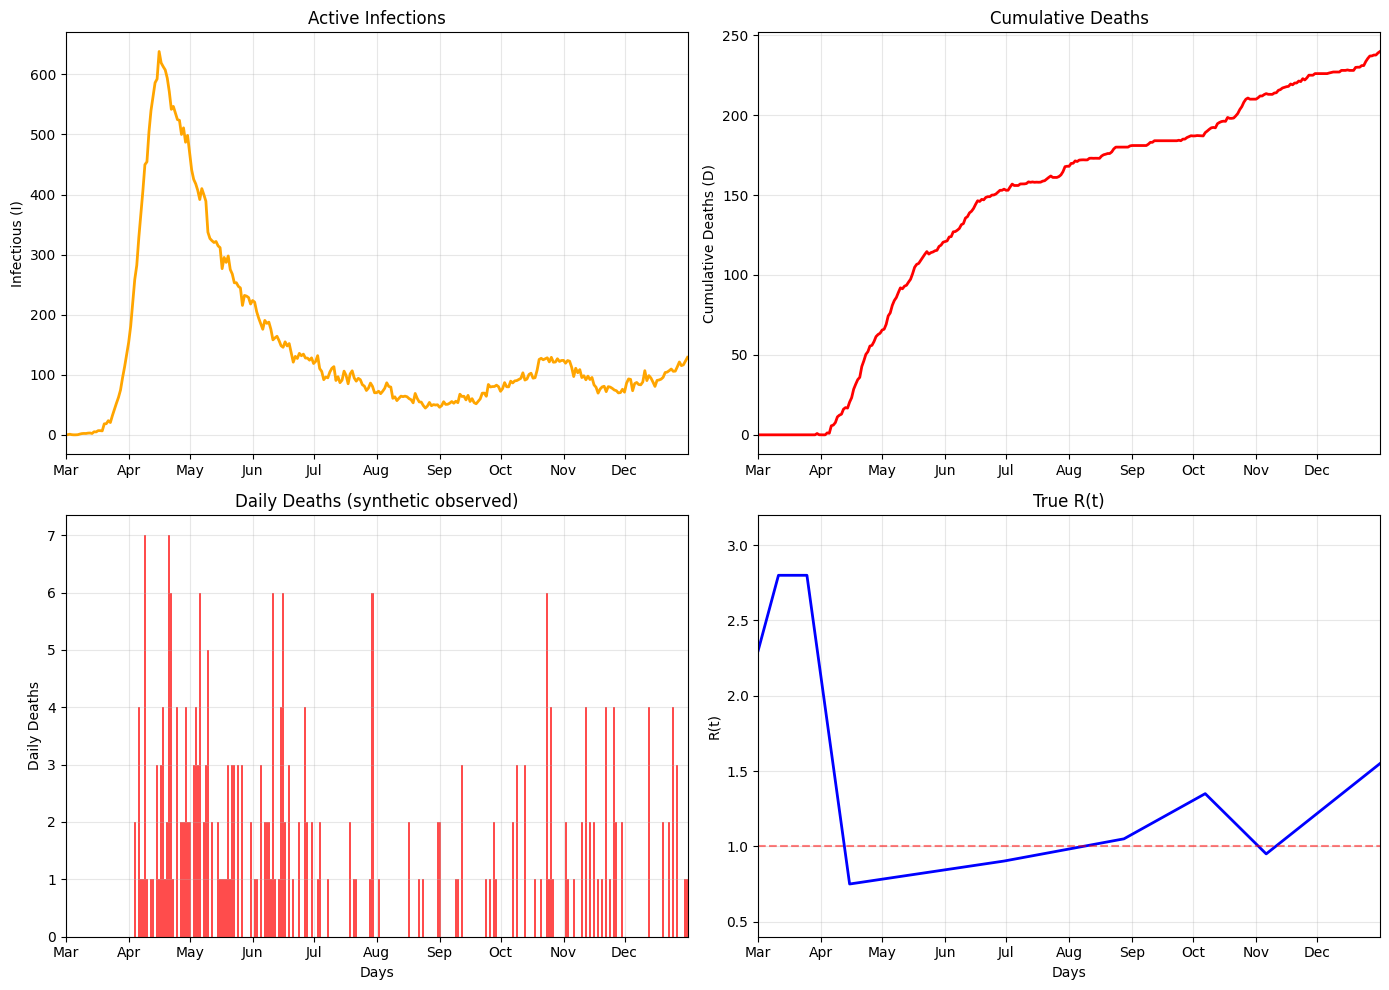

Peak daily deaths day: 39 (month label ticks shown on plots)
Total deaths: 262


In [24]:
# Plot the epidemic trajectory
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

t = np.array(result["t"])

# Infections
ax = axes[0, 0]
ax.plot(t, result["I"], "orange", linewidth=2)
ax.set_ylabel("Infectious (I)")
ax.set_title("Active Infections")
ax.set_xlim(0, T)

# Deaths (cumulative)
ax = axes[0, 1]
ax.plot(t, result["D"], "red", linewidth=2)
ax.set_ylabel("Cumulative Deaths (D)")
ax.set_title("Cumulative Deaths")
ax.set_xlim(0, T)

# Daily deaths (observed)
ax = axes[1, 0]
ax.bar(t, observed_deaths, color="red", alpha=0.7, width=1)
ax.set_xlabel("Days")
ax.set_ylabel("Daily Deaths")
ax.set_title("Daily Deaths (synthetic observed)")
ax.set_xlim(0, T)

# R(t) for reference
ax = axes[1, 1]
ax.plot(t, true_R_t, "b-", linewidth=2)
ax.axhline(y=1.0, color="r", linestyle="--", alpha=0.5)
ax.set_xlabel("Days")
ax.set_ylabel("R(t)")
ax.set_title("True R(t)")
ax.set_xlim(0, T)
ax.set_ylim(0.4, 3.2)

# Month labels
for ax in axes.flat:
    ax.set_xticks(month_days)
    ax.set_xticklabels(months)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Lightweight shape checks (qualitative UK-2020 pattern)
daily = observed_deaths.astype(float)
peak_day = int(np.argmax(daily))
print(f"Peak daily deaths day: {peak_day} (month label ticks shown on plots)")
print(f"Total deaths: {daily.sum():.0f}")


## 4. Bayesian inference setup

We estimate $R(t)$ using a **piecewise-constant** parameterization with 2-week intervals.

### Random-walk prior (non-centred / innovations parameterisation)

Directly optimising/sampling the correlated states $(\log R_k)$ can be difficult.
Instead, we use a non-centred parameterisation (common in epidemic models like *epidemia*):

- $x_1 = \log R_1$
- $z_k \sim \mathcal{N}(0, 1)$ innovations for increments
- $\sigma_{RW} > 0$ random-walk volatility

and define the path deterministically:

$$x_k = x_1 + \sum_{j=2}^k \sigma_{RW} z_j$$

This makes optimisation and HMC geometry much better.

### Likelihood

We use a (synthetic) Poisson likelihood for daily deaths:

$$y_t \sim \text{Poisson}(\lambda_t), \quad \lambda_t = \text{softplus}(\hat{y}_t)$$

The `softplus` keeps the likelihood smooth while enforcing positivity.

In [25]:
# Define the inference window (2-week intervals)
interval_days = 14
n_intervals = (T + 1 + interval_days - 1) // interval_days

print(f"Number of interval R(t) parameters: {n_intervals}")
print(f"Interval length: {interval_days} days")


Number of interval R(t) parameters: 22
Interval length: 14 days


In [26]:
def expand_R_intervals(R_intervals, T, interval_days=14):
    """Expand interval R values to daily R(t) array."""
    R_daily = jnp.zeros(T + 1)
    K = int(R_intervals.shape[0])
    for i in range(K):
        start = i * interval_days
        end = min((i + 1) * interval_days, T + 1)
        R_daily = R_daily.at[start:end].set(R_intervals[i])
    return R_daily

# Test the expansion
_test_R = jnp.ones(n_intervals) * 1.5
_test_expanded = expand_R_intervals(_test_R, T, interval_days)
print(f"Expanded R(t) shape: {_test_expanded.shape}")


Expanded R(t) shape: (307,)


In [27]:
def unpack_rw_params(theta, n_intervals):
    """Unpack non-centred RW parameters.

    theta = [x1, log_sigma, z_2, ..., z_K]
    """
    x1 = theta[0]
    log_sigma = theta[1]
    sigma = jnp.exp(log_sigma)
    z = theta[2:]
    if z.shape[0] != (n_intervals - 1):
        raise ValueError("Incorrect theta length")

    # Build x_k = x1 + sigma * cumsum([0, z])
    increments = jnp.concatenate([jnp.zeros((1,)), z])
    x = x1 + sigma * jnp.cumsum(increments)
    return x, sigma


def log_prior(theta, n_intervals):
    """Smooth priors for the non-centred RW parameterisation."""
    x, sigma = unpack_rw_params(theta, n_intervals)

    # Prior on x1 (log R at start)
    lp_x1 = -0.5 * ((x[0] - jnp.log(2.5)) / 0.6) ** 2

    # Prior on sigma (RW volatility) via log_sigma
    # Weakly informative: log_sigma ~ N(log(0.2), 0.5^2)
    log_sigma = theta[1]
    lp_log_sigma = -0.5 * ((log_sigma - jnp.log(0.2)) / 0.5) ** 2

    # Innovations z ~ N(0,1)
    z = theta[2:]
    lp_z = -0.5 * jnp.sum(z**2)

    return lp_x1 + lp_log_sigma + lp_z


In [28]:
# Create a pre-compiled model for efficient inference
# NOTE: current emidm API returns a model function that takes an *optional params dict*.
print("Creating pre-compiled SAFIR model for inference...")

safir_model = make_diff_safir_model(
    population=population,
    contact_matrix=contact_matrix,
    R0=2.5,
    T=T,
    dt=0.5,
    seed=0,
    config=DiffConfig(tau=0.3, hard=False),
    I0=5,
)

print("Model created!")

obs_deaths_jnp = jnp.asarray(observed_deaths)

@jax.jit
def log_likelihood(theta):
    """Poisson log-likelihood for daily deaths under the RW-parameterised R(t)."""
    log_R_intervals, _sigma = unpack_rw_params(theta, n_intervals)
    R_intervals = jnp.exp(log_R_intervals)
    R_t = expand_R_intervals(R_intervals, T, interval_days)

    # Call the pre-compiled model using params dict
    result = safir_model({"R_t": R_t})

    predicted_D = result["D"]
    predicted_daily = jnp.diff(predicted_D, prepend=0.0)

    # Smooth positivity to avoid kinks; add tiny epsilon for numerical stability
    lam = jax.nn.softplus(predicted_daily) + 1e-6

    # Poisson log-likelihood (up to constant)
    return jnp.sum(obs_deaths_jnp * jnp.log(lam) - lam)


@jax.jit
def log_posterior(theta):
    return log_likelihood(theta) + log_prior(theta, n_intervals)


print("Compiling inference functions...")
init_theta = jnp.concatenate(
    [
        jnp.array([jnp.log(1.6), jnp.log(0.15)]),
        jnp.zeros((n_intervals - 1,)),
    ]
)
_ = log_posterior(init_theta).block_until_ready()
print("Done! Inference functions are JIT-compiled.")


Creating pre-compiled SAFIR model for inference...
Model created!
Compiling inference functions...
Done! Inference functions are JIT-compiled.


## 5. Maximum a posteriori (MAP)

Before running full MCMC, we find a MAP estimate using gradient-based optimisation. This:

- Validates the model and likelihood are differentiable end-to-end
- Produces a reasonable starting point for NUTS

We optimise the non-centred parameter vector:

`theta = [x1, log_sigma_rw, z_2, ..., z_K]`

In [29]:
# Define negative log-posterior for minimization
@jax.jit
def neg_log_posterior(theta):
    return -log_posterior(theta)

print("Finding MAP estimate...")
print(f"Initial negative log-posterior: {neg_log_posterior(init_theta):.2f}")


Finding MAP estimate...
Initial negative log-posterior: 720.26


In [30]:
# MAP optimisation
# We avoid requiring optax by using a simple JAX gradient descent loop.
# NOTE: We keep the number of steps modest to ensure this notebook executes
# reliably on typical machines.

def run_map_optim(theta0, n_steps=80, learning_rate=0.03):
    @jax.jit
    def step(theta):
        loss, grads = jax.value_and_grad(neg_log_posterior)(theta)
        theta = theta - learning_rate * grads
        return theta, loss

    theta = theta0
    losses = []
    for _ in range(int(n_steps)):
        theta, loss = step(theta)
        losses.append(loss)

    return theta, jnp.stack(losses)

map_theta, loss_trace = run_map_optim(init_theta, n_steps=80, learning_rate=0.03)

map_log_R_intervals, map_sigma = unpack_rw_params(map_theta, n_intervals)
map_R_intervals = jnp.exp(map_log_R_intervals)

print(f"Final negative log-posterior: {loss_trace[-1]:.2f}")
print(f"MAP sigma_rw: {map_sigma:.3f}")


Final negative log-posterior: 1673.73
MAP sigma_rw: 0.431


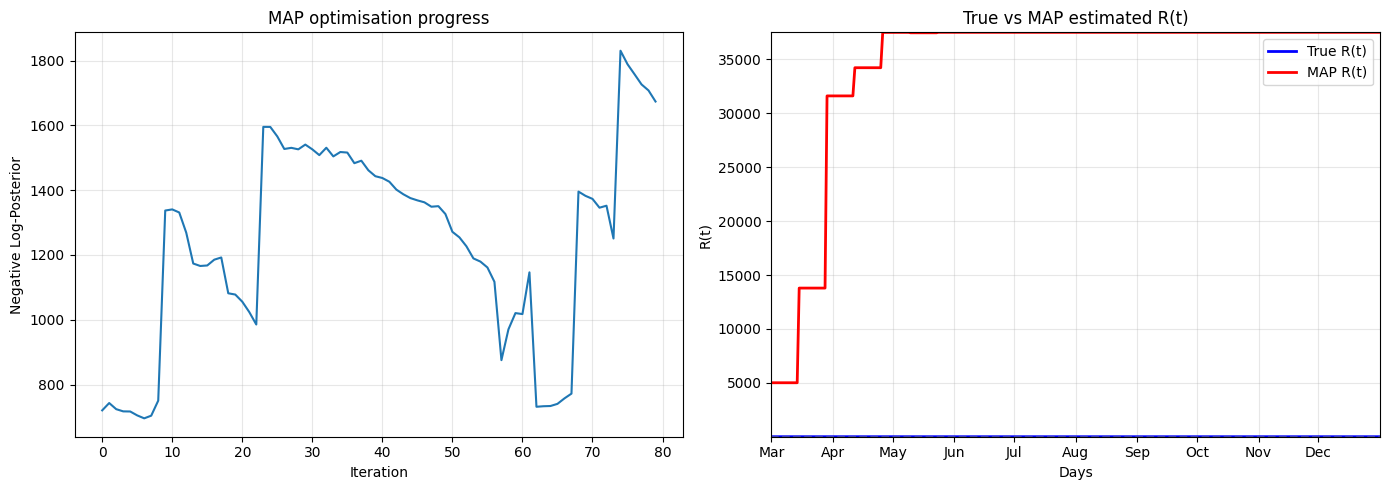

In [36]:
# Plot optimisation progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(np.array(loss_trace))
ax.set_xlabel("Iteration")
ax.set_ylabel("Negative Log-Posterior")
ax.set_title("MAP optimisation progress")
ax.grid(alpha=0.3)

ax = axes[1]
map_R_expanded = expand_R_intervals(map_R_intervals, T, interval_days)
ax.plot(np.arange(T + 1), true_R_t, "b-", linewidth=2, label="True R(t)")
ax.plot(np.arange(T + 1), np.array(map_R_expanded), "r-", linewidth=2, label="MAP R(t)")
ax.axhline(y=1.0, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("Days")
ax.set_ylabel("R(t)")
ax.set_title("True vs MAP estimated R(t)")
ax.legend()
ax.set_xlim(0, T)
ax.set_ylim(0.4, map_R_expanded.max())
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


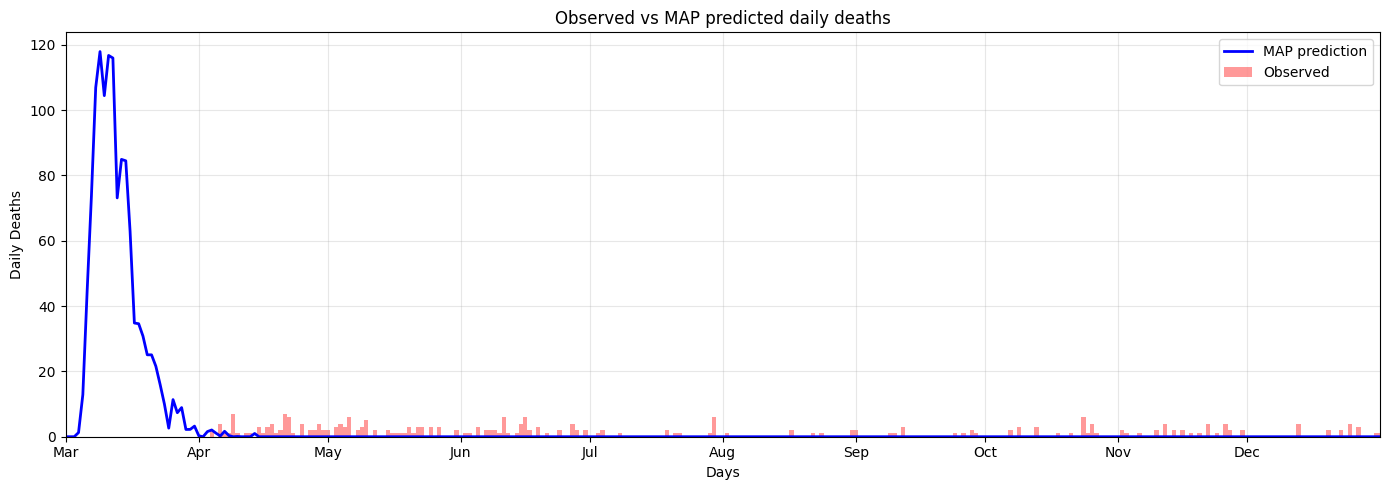

Spring peak ~day 39, value 7.0
Summer level (mean, days 140-199): 0.42
Winter peak ~day 237, value 6.0
Spring peak / summer mean: 16.8
Winter peak / summer mean: 14.399999999999999


In [32]:
# Compare predicted vs observed deaths with MAP estimate
map_R_expanded = expand_R_intervals(map_R_intervals, T, interval_days)

map_result = run_diff_safir_simulation(
    population=population,
    contact_matrix=contact_matrix,
    R0=2.5,
    R_t=np.array(map_R_expanded),
    T=T,
    dt=0.5,
    seed=42,
    config=obs_config,
    I0=30,
)

map_daily_deaths = np.diff(np.array(map_result["D"]), prepend=0)
map_daily_deaths = np.clip(map_daily_deaths, 0.0, None)

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(np.arange(T + 1), observed_deaths, color="red", alpha=0.4, width=1, label="Observed")
ax.plot(np.arange(T + 1), map_daily_deaths, "b-", linewidth=2, label="MAP prediction")
ax.set_xlabel("Days")
ax.set_ylabel("Daily Deaths")
ax.set_title("Observed vs MAP predicted daily deaths")
ax.legend()
ax.set_xlim(0, T)
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# UK-2020-like shape checks (qualitative)
daily_obs = observed_deaths.astype(float)

spring_peak = float(np.max(daily_obs[0:110]))
summer_level = float(np.mean(daily_obs[140:200]))
winter_peak = float(np.max(daily_obs[220:]))

spring_peak_day = int(np.argmax(daily_obs[0:110]))
winter_peak_day = int(np.argmax(daily_obs[220:])) + 220

print(f"Spring peak ~day {spring_peak_day}, value {spring_peak:.1f}")
print(f"Summer level (mean, days 140-199): {summer_level:.2f}")
print(f"Winter peak ~day {winter_peak_day}, value {winter_peak:.1f}")

# Expect: big spring wave, suppressed summer, resurgence in late year
print("Spring peak / summer mean:", spring_peak / max(summer_level, 1e-6))
print("Winter peak / summer mean:", winter_peak / max(summer_level, 1e-6))


## 7. Summary

In this notebook, we demonstrated:

1. **Setting up a realistic SAFIR model** with UK demographics and contact patterns
2. **Simulating a UK 2020-like epidemic** with time-varying R(t) capturing:
   - Initial exponential growth (March)
   - First lockdown impact (April-June)
   - Summer reopening (July-September)
   - Second lockdown (October-November)
   - Alpha variant emergence (December)
3. **Bayesian inference** for estimating R(t) from death data using **emidm**'s differentiable SAFIR model:
   - Piecewise constant parameterization (2-week intervals)
   - Random walk prior for smoothness
   - Poisson likelihood for death counts
   - MAP estimation via gradient descent

### Key Insights

- **Differentiable models enable gradient-based inference** - Much faster than derivative-free methods
- **End-to-end differentiability** - Gradients flow through the entire SAFIR simulation
- **JIT compilation** - Using `@jax.jit` on the log-posterior makes inference much faster
- **Death data has a lag** - R(t) changes are reflected in deaths ~2-3 weeks later

### Extensions

- Use a Gaussian Process prior for smoother R(t) estimates
- Incorporate multiple data streams (cases, hospitalizations, deaths)
- Add observation model for reporting delays and noise
- Estimate other parameters (IFR, hospitalization rates) jointly